In [161]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../')

from main import load_and_prepare_sessions
from processing.session_sampling import MiceAnalysis
from analysis.timepoint_analysis import sample_signals_and_metrics, sample_low_and_high_signals
from config import all_brain_regions, all_event_types, all_metrics
from itertools import product
import numpy as np
from utils import mouse_br_events_count

from sklearn.manifold import TSNE
import torch
from torch.utils.data import DataLoader, TensorDataset

window_size = 5
window = np.ones(window_size) / window_size

sessions = load_and_prepare_sessions("../../../Baseline", load_from_pickle=True, remove_bad_signal_sessions=True)
mouse_analyser = MiceAnalysis(sessions)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [162]:
# Generate all aggregated signals
all_event_signals = []
labels = []

for mouse in mouse_analyser.mice_dict.values():
    mouse_sessions = mouse.sessions
    for brain_region, event in product(all_brain_regions, all_event_types[:5]):
        if mouse_br_events_count(mouse, brain_region, event) < 15:
            continue
        if brain_region != 'VS':
            continue
        if event == 'cor_reject':
            continue
        mouse_signals = [] 
        for session in mouse_sessions:
            if session.signal_info.get((brain_region, event)) is None:
                continue
            signals = sample_signals_and_metrics([session], event, brain_region)[0]
            signals = np.array([np.convolve(signal, window, mode='same') for signal in signals])
            mouse_signals.append(signals[:, 150:250])
        if len(mouse_signals) == 0:
            continue
        mouse_signals = np.vstack(mouse_signals)
        sample_idxs = np.random.choice(len(mouse_signals), 100, replace=True)
        mouse_signals = mouse_signals[sample_idxs]

        # Cumulative events data for the current metric
        part_value = mouse.metric_container.data['participation']
        if len(mouse_signals) > 5:
            for i in range(5):
                all_event_signals.append(np.mean(mouse_signals[i::5], axis=0))
                labels.append((mouse.mouse_id, brain_region, event, part_value))

all_event_signals = np.array(all_event_signals)

In [163]:
tsne = TSNE(n_components=2, max_iter=750)
signals_embedded = tsne.fit_transform(all_event_signals.reshape(all_event_signals.shape[0], -1))

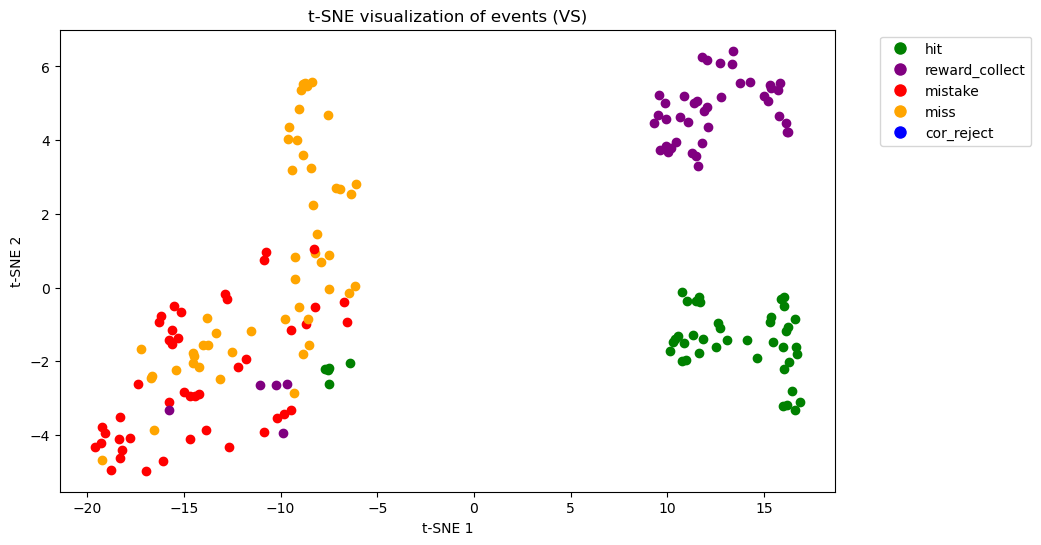

In [165]:
import matplotlib.pyplot as plt
import numpy as np

# Define mappings
colors = {'hit': 'green', 
        'reward_collect': 
        'purple', 'mistake': 
        'red', 'miss':'orange', 
        'cor_reject':'blue'}

shapes = {'DMS': 'o', 'DLS': 's', 'VS': 'o'}

brain_reg_to_color = {'VS': 'purple',
                      'DMS': 'forestgreen',
                      'DLS': 'C0'}

max_participation = max([label[-1] for label in labels])
labels = [(label[0], label[1], label[2], label[3] / max_participation) for label in labels]

plt.figure(figsize=(10, 6))

# Iterate over each point to plot
for point, label in zip(signals_embedded, labels):
    color = colors[label[2]]
    # color = brain_reg_to_color[label[1]]
    shape = shapes[label[1]]
    plt.scatter(point[0], point[1], c=color, marker=shape)

# Create custom legends
from matplotlib.lines import Line2D
color_legend = [Line2D([0], [0], marker='o', color='w', label=key, 
                    markerfacecolor=val, markersize=10) for key, val in colors.items()]

# Display legends
plt.legend(handles=color_legend, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title(f't-SNE visualization of events (VS)')
plt.show()